In [1]:
import os
DATA_DIR = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
!ls $DATA_DIR
INPUT_SHAPE = (224, 224, 3)

stage_2_sample_submission.csv  stage_2_test  stage_2_train  stage_2_train.csv


In [2]:
import pandas as pd

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img


def read_trainset(filename=DATA_DIR+"stage_2_train.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    duplicates_to_remove = [
        56346,56347,56348,56349,
        56350,56351,1171830,1171831,
        1171832,1171833,1171834,1171835,
        3705312,3705313,3705314,3705315,
        3705316,3705317,3842478,3842479,
        3842480,3842481,3842482,3842483
    ]
    
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

In [3]:
df = read_trainset()

In [4]:
import pydicom
import numpy as np
import cv2
X,y = [], []

lol = pd.DataFrame()
for key in df['Label'].keys():
    lol[key] = df[('Label', key)]

for idx in df[:2000].index:
    dcm = pydicom.dcmread(DATA_DIR+'stage_2_train/'+idx+'.dcm')
    arr = bsb_window(dcm)
    arr = cv2.resize(arr, (224,224), interpolation=cv2.INTER_LINEAR) # resize to (224,224)
    X.append(arr)
    labels = lol.loc[idx]
    y.append(labels)
    

X = np.array(X)
y = np.array(y)

In [11]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras import layers
import numpy as np

conv_base = VGG16(weights='imagenet', input_shape=INPUT_SHAPE ,include_top=False)

conv_base.trainable = False
model = keras.models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    #loss='categorical_crossentropy', # mutually exclusive
    optimizer=keras.optimizers.Adam(lr=1e-3),
    metrics=['accuracy']
    
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 1542      
Total params: 40,669,766
Trainable params: 25,955,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [6]:
hist = model.fit(X,y,
                 epochs=15,
                 verbose=True)

Epoch 1/15
2000/2000 [==============================] - 9s 4ms/step - loss: 0.3414 - accuracy: 0.9229
Epoch 2/15
2000/2000 [==============================] - 6s 3ms/step - loss: 0.1636 - accuracy: 0.9441
Epoch 3/15
2000/2000 [==============================] - 6s 3ms/step - loss: 0.1217 - accuracy: 0.9573
Epoch 4/15
2000/2000 [==============================] - 6s 3ms/step - loss: 0.1042 - accuracy: 0.9623
Epoch 5/15
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0841 - accuracy: 0.9683
Epoch 6/15
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0673 - accuracy: 0.9747
Epoch 7/15
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0531 - accuracy: 0.9815
Epoch 8/15
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0448 - accuracy: 0.9839
Epoch 9/15
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0279 - accuracy: 0.9919
Epoch 10/15
2000/2000 [==============================] - 6s 3ms/step - loss: 0.028

In [7]:
p = model.predict(X)

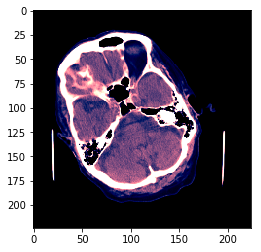

In [8]:
import matplotlib.pyplot as plt

plt.imshow(X[0])


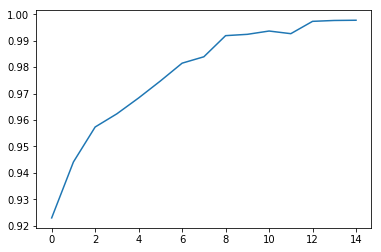

In [9]:
plt.plot(hist.history['accuracy'])
plt.show()

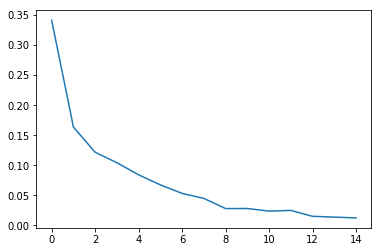

In [10]:
plt.plot(hist.history['loss'])
plt.show()